In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL of the Basketball Reference NBA player stats page (example for 2023-2024 season)
url = "https://www.basketball-reference.com/leagues/NBA_2024_per_game.html"

# Send a request to the webpage
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Parse the webpage content
    soup = BeautifulSoup(response.content, 'html.parser')

    # Print out the soup content to inspect
    # print(soup.prettify())

    # Find the table containing player stats
    table = soup.find('table', {'id': 'per_game_stats'})

    # Extract table headers
    headers = [th.text for th in table.find('thead').find_all('th')][1:]  # Skip the first header

    # Extract player stats
    rows = table.find('tbody').find_all('tr')
    players_data = []
    for row in rows:
        if row.find('th', {'scope': 'row'}) is not None:  # Skip header rows within tbody
            stats = [td.text for td in row.find_all('td')]
            players_data.append(stats)

    # Convert the data into a DataFrame
    df = pd.DataFrame(players_data, columns=headers)

    # Save the DataFrame to a CSV file
    df.to_csv('nba_player_stats.csv', index=False)

    print("Data has been scraped and saved to nba_player_stats.csv")
else:
    print(f"Failed to retrieve the webpage. Status code: {response.status_code}")


Data has been scraped and saved to nba_player_stats.csv


In [2]:
#filtering the data
filtered_df = df.drop_duplicates(subset="Player", keep="first")

for index, row in filtered_df.iterrows():
    if "TOT" in row['Tm']:
        player_value = row['Player']

        df = df[~df['Tm'].str.contains('TOT')]
        max_g_value_for_player = df.loc[df['Player'] == player_value, 'G'].max()
        
        max_g_index = df.loc[(df['Player'] == player_value) & (df['G'] == max_g_value_for_player)].index[0]
        
        filtered_df.loc[index, 'Pos'] = df.loc[max_g_index, 'Pos']


filtered_df.to_csv("filtered.csv")

   Unnamed: 0                    Player Pos  Age   Tm   G  GS    MP   FG  \
0           0          Precious Achiuwa  PF   24  TOT  74  18  21.9  3.2   
1           3               Bam Adebayo   C   26  MIA  71  71  34.0  7.5   
2           4              Ochai Agbaji  SG   23  TOT  78  28  21.0  2.3   
3           7              Santi Aldama  PF   23  MEM  61  35  26.5  4.0   
4           8  Nickeil Alexander-Walker  SG   25  MIN  82  20  23.4  2.9   

    FGA  ...    FT%  ORB  DRB   TRB  AST  STL  BLK  TOV   PF   PTS  
0   6.3  ...  0.616  2.6  4.0   6.6  1.3  0.6  0.9  1.1  1.9   7.6  
1  14.3  ...  0.755  2.2  8.1  10.4  3.9  1.1  0.9  2.3  2.2  19.3  
2   5.6  ...  0.661  0.9  1.8   2.8  1.1  0.6  0.6  0.8  1.5   5.8  
3   9.3  ...  0.621  1.2  4.6   5.8  2.3  0.7  0.9  1.1  1.5  10.7  
4   6.6  ...  0.800  0.4  1.6   2.0  2.5  0.8  0.5  0.9  1.7   8.0  

[5 rows x 30 columns]
             G         GS         MP        FG       FGA       FG%        3P  \
Pos                       

IndexError: index 3 is out of bounds for axis 0 with size 3

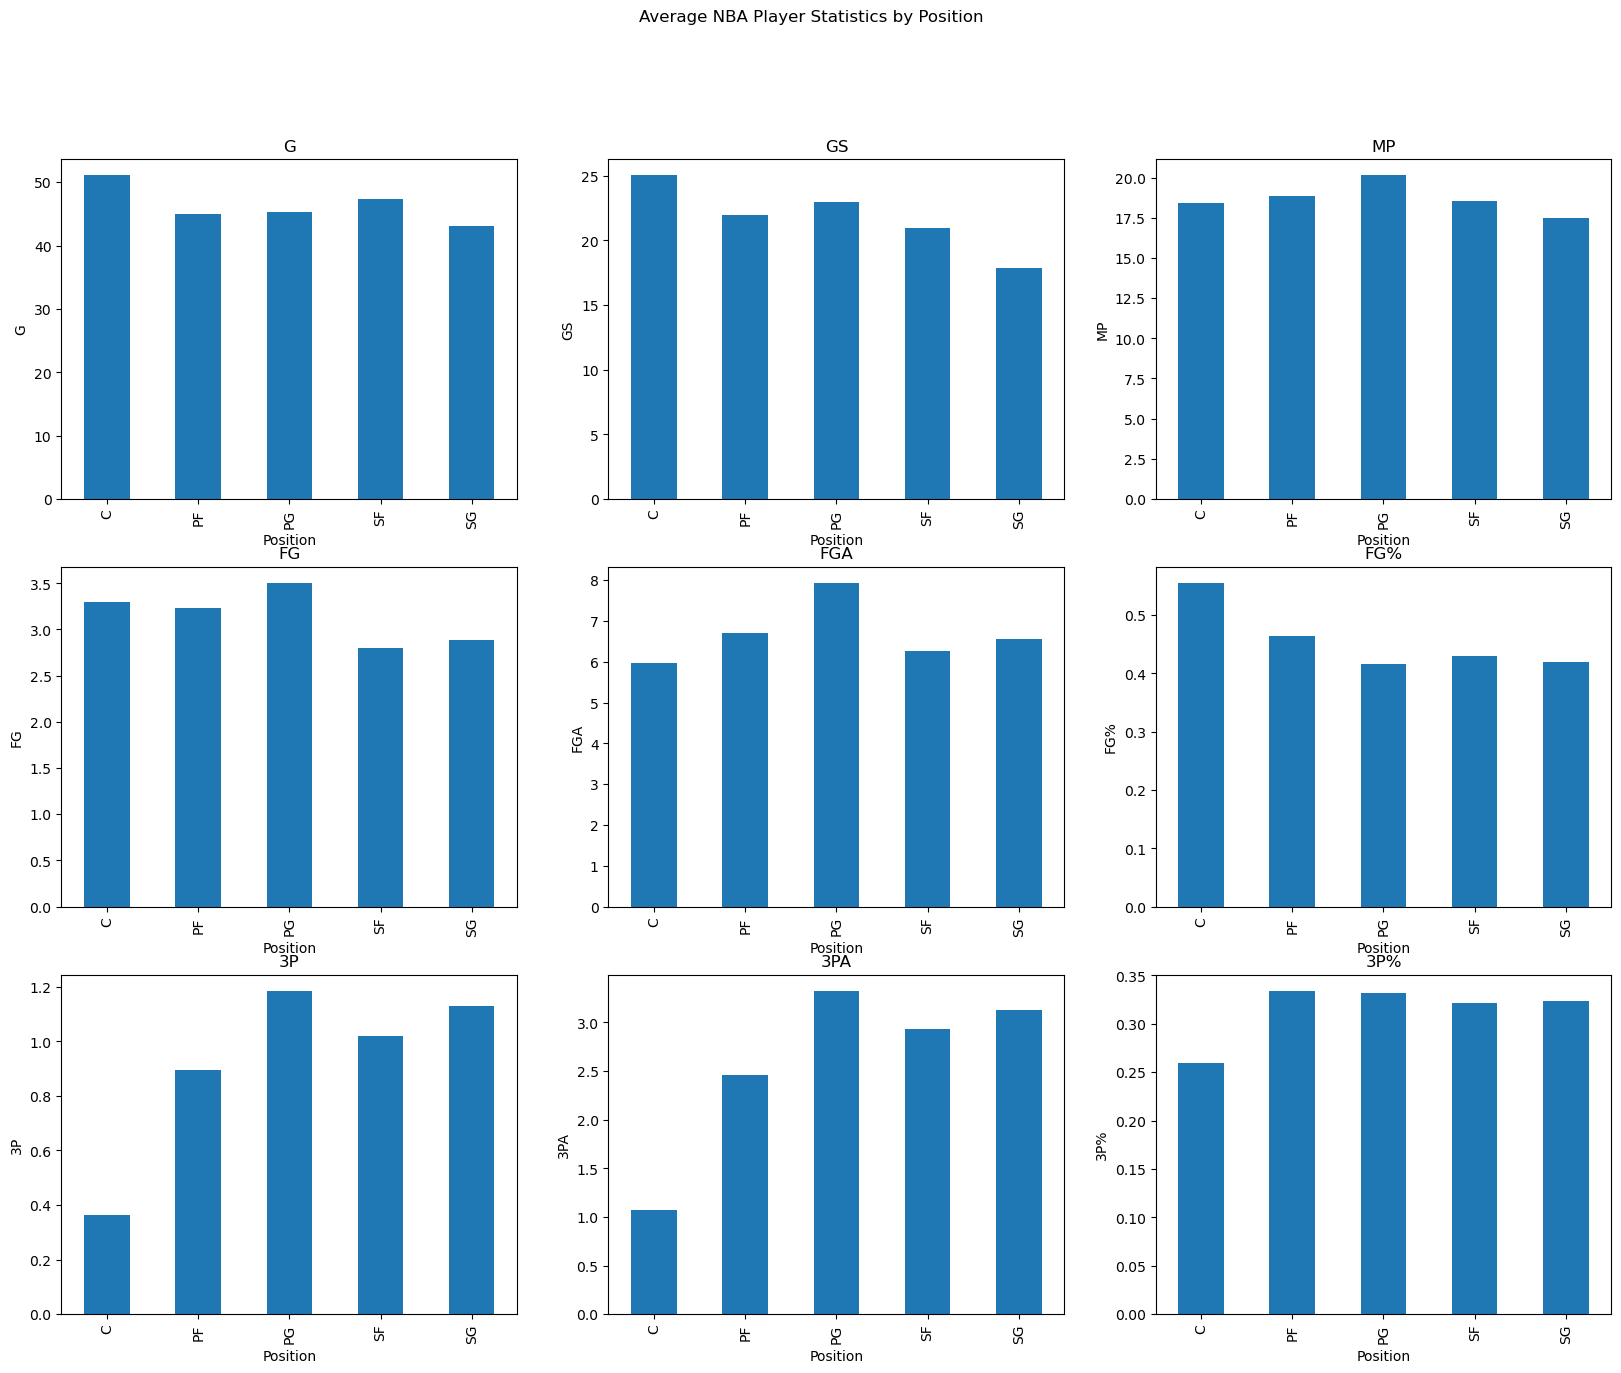

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
df = pd.read_csv('filtered.csv')

# Print the first few rows to inspect the data
print(df.head())

# Identify numeric columns
numeric_cols = df.columns[5:]  # Assuming the first 5 columns are non-numeric
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Drop non-numeric columns for the aggregation
df_cleaned = df.dropna(subset=['Pos'])

# Group by position and calculate the average for each statistic
average_stats = df_cleaned.groupby('Pos')[numeric_cols].mean()

# Print the average statistics
print(average_stats)

# Plot the average statistics for each position
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
fig.suptitle('Average NBA Player Statistics by Position')

# List of statistics to plot
stats_to_plot = average_stats.columns

# Create subplots for each statistic
for i, stat in enumerate(stats_to_plot):
    row, col = divmod(i, 3)
    average_stats[stat].plot(kind='bar', ax=axes[row, col], title=stat)
    axes[row, col].set_xlabel('Position')
    axes[row, col].set_ylabel(stat)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.95)

# Show the plots
plt.show()


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('filtered.csv')

# Identify numeric columns
numeric_cols = df.columns[5:]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Drop rows with missing numeric data
df_cleaned = df.dropna(subset=numeric_cols)

# Standardize the data
scaler = StandardScaler()

df_scaled = scaler.fit_transform(df_cleaned[numeric_cols])

# Perform K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)

df_cleaned['cluster'] = kmeans.fit_predict(df_scaled)

# Create a color palette for positions
position_palette = {
    'PG': 'red',
    'SG': 'green',
    'SF': 'blue',
    'PF': 'purple',
    'C': 'orange'
}

# Visualize the clusters by position
plt.figure(figsize=(10, 6))

sns.scatterplot(x='PTS', y='AST', hue='Pos', data=df_cleaned, palette=position_palette)

plt.title('Player Clustering by Position')

plt.xlabel('Points per Game')

plt.ylabel('Assists per Game')

plt.legend(title='Position')

plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('filtered.csv')

# Identify numeric columns
numeric_cols = df.columns[5:]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Create box plots for points, assists, and rebounds by position
stats_to_plot = ['PTS', 'AST', 'TRB']

plt.figure(figsize=(18, 6))
for i, stat in enumerate(stats_to_plot, 1):
    
    plt.subplot(1, 3, i)
    
    sns.boxplot(x='Pos', y=stat, data=df)
    
    plt.title(f'{stat} by Position')
    
    plt.xlabel('Position')
    
    plt.ylabel(stat)

plt.tight_layout()

plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# Function to create radar charts
def radar_chart(player_data, player_name, position):
    categories = list(player_data.keys())
   
    values = list(player_data.values())

    values += values[:1]
    
    angles = [n / float(len(categories)) * 2 * np.pi for n in range(len(categories))]

    angles += angles[:1]

    ax = plt.subplot(111, polar=True)
    
    plt.xticks(angles[:-1], categories, color='grey', size=8)
    
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=position)
    
    ax.fill(angles, values, alpha=0.4)
    
    plt.legend(loc='upper right')

# Load the data
df = pd.read_csv('filtered.csv')

# Identify numeric columns
numeric_cols = df.columns[5:]

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Drop rows with missing numeric data
df_cleaned = df.dropna(subset=numeric_cols).copy()

# Normalize the data
scaler = StandardScaler()

df_cleaned[numeric_cols] = scaler.fit_transform(df_cleaned[numeric_cols])

# Select one player from each position
positions = df_cleaned['Pos'].unique()

top_players = df_cleaned.groupby('Pos').apply(lambda x: x.head(1)).reset_index(drop=True)

# Plot radar charts for top players
plt.figure(figsize=(10, 10))

for index, player in top_players.iterrows():

    player_data = player[numeric_cols].to_dict()
    
    radar_chart(player_data, player['Player'], player['Pos'])
    
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# Function to create radar charts for ultimate player
def radar_chart(player_data, labels, title):
    categories = list(player_data.keys())
    
    values = list(player_data.values())

    values += values[:1]
    
    angles = [n / float(len(categories)) * 2 * np.pi for n in range(len(categories))]
    
    angles += angles[:1]

    ax = plt.subplot(111, polar=True)
    
    plt.xticks(angles[:-1], categories, color='grey', size=8)
    
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=title)
    
    ax.fill(angles, values, alpha=0.4)
    
    for i, label in enumerate(labels):
    
        angle = angles[i]
        
        x = angle * 180 / np.pi
        
        ha = 'right' if x > 180 else 'left'
        
        ax.text(angle, values[i] + 0.1, label, size=8, horizontalalignment=ha, verticalalignment='center', color='blue')
    
    plt.legend(loc='upper right')

# Load the data
df = pd.read_csv('filtered.csv')

# Identify numeric columns
numeric_cols = df.columns[5:]

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Drop rows with missing numeric data
df_cleaned = df.dropna(subset=numeric_cols).copy()

# Normalize the data
scaler = StandardScaler()

df_cleaned[numeric_cols] = scaler.fit_transform(df_cleaned[numeric_cols])

# Determine the ultimate player stats and corresponding positions
ultimate_player_stats = df_cleaned[numeric_cols].max()

positions = df_cleaned[numeric_cols].idxmax().apply(lambda x: df_cleaned.loc[x, 'Pos'])

# Prepare the data for the radar chart
ultimate_player_data = ultimate_player_stats.to_dict()

position_labels = positions.tolist()

# Plot the radar chart for the ultimate player
plt.figure(figsize=(10, 10))

radar_chart(ultimate_player_data, position_labels, 'Ultimate Player')

plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# Function to create radar charts
def radar_chart(player_data, player_name, ax):
    categories = list(player_data.keys())
    
    values = list(player_data.values())

    values += values[:1]
    
    angles = [n / float(len(categories)) * 2 * np.pi for n in range(len(categories))]
    
    angles += angles[:1]

    ax.set_xticks(angles[:-1])
    
    ax.set_xticklabels(categories, color='grey', size=8)
    
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=player_name)
    
    ax.fill(angles, values, alpha=0.4)

# Load the data
df = pd.read_csv('filtered.csv')

# Identify numeric columns
numeric_cols = df.columns[5:]

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Drop rows with missing numeric data
df_cleaned = df.dropna(subset=numeric_cols).copy()

# Normalize the data
scaler = StandardScaler()

df_cleaned[numeric_cols] = scaler.fit_transform(df_cleaned[numeric_cols])

# Positions to analyze
positions = df_cleaned['Pos'].unique()

# Create a plot for each position
for position in positions:
    
    # Select top 5 players for the current position
    top_players = df_cleaned[df_cleaned['Pos'] == position].head(5)
    
    # Prepare the plot
    fig, axs = plt.subplots(1, 1, figsize=(8, 8), subplot_kw=dict(polar=True))

    fig.suptitle(f'Top 5 Players - {position}', size=16)
    
    # Plot radar charts for the top players in the current position
    for index, player in top_players.iterrows():
    
        player_data = player[numeric_cols].to_dict()
        
        radar_chart(player_data, player['Player'], axs)
    
    axs.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    
    plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# Function to create radar charts
def radar_chart(player_data, player_name, ax):
    categories = list(player_data.keys())
    
    values = list(player_data.values())

    values += values[:1]
    
    angles = [n / float(len(categories)) * 2 * np.pi for n in range(len(categories))]
    
    angles += angles[:1]

    ax.set_xticks(angles[:-1])
    
    ax.set_xticklabels(categories, color='grey', size=8)
    
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=player_name)
    
    ax.fill(angles, values, alpha=0.4)

# Load the data
df = pd.read_csv('filtered.csv')

# prep data
numeric_cols = df.columns[5:]

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Drop rows with missing numeric data
df_cleaned = df.dropna(subset=numeric_cols).copy()

# Normalize the data
scaler = StandardScaler()

df_cleaned[numeric_cols] = scaler.fit_transform(df_cleaned[numeric_cols])

# Define an offensive score by summing up relevant offensive metrics
df_cleaned['OffensiveScore'] = df_cleaned[['PTS', 'AST', 'FG%', '3P%', 'FT%']].sum(axis=1)

# Select top offensive players based on the offensive score
top_offensive_players = df_cleaned.nlargest(5, 'OffensiveScore')

# Prepare the plot
fig, axs = plt.subplots(1, 1, figsize=(10, 10), subplot_kw=dict(polar=True))

fig.suptitle('Top 5 Offensive Players', size=16)

# Plot radar charts for the top offensive players
for index, player in top_offensive_players.iterrows():

    player_data = player[['PTS', 'AST', 'FG%', '3P%', 'FT%']].to_dict()
    
    radar_chart(player_data, player['Player'], axs)

axs.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# Function to create radar charts
def radar_chart(player_data, player_name, ax):
    categories = list(player_data.keys())
    
    values = list(player_data.values())

    values += values[:1]
    
    angles = [n / float(len(categories)) * 2 * np.pi for n in range(len(categories))]
    
    angles += angles[:1]

    ax.set_xticks(angles[:-1])
    
    ax.set_xticklabels(categories, color='grey', size=8)
    
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=player_name)
    
    ax.fill(angles, values, alpha=0.4)

# Load the data
df = pd.read_csv('filtered.csv')

# Identify numeric columns
numeric_cols = df.columns[5:]

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Drop rows with missing numeric data
df_cleaned = df.dropna(subset=numeric_cols).copy()

# Normalize the data
scaler = StandardScaler()

df_cleaned[numeric_cols] = scaler.fit_transform(df_cleaned[numeric_cols])

# Define a defensive score by summing up relevant defensive metrics
df_cleaned['DefensiveScore'] = df_cleaned[['TRB', 'STL', 'BLK']].sum(axis=1)

# Select top defensive players based on the defensive score
top_defensive_players = df_cleaned.nlargest(5, 'DefensiveScore')

# Prepare the plot
fig, axs = plt.subplots(1, 1, figsize=(10, 10), subplot_kw=dict(polar=True))

fig.suptitle('Top 5 Defensive Players', size=16)

# Plot radar charts for the top defensive players
for index, player in top_defensive_players.iterrows():

    player_data = player[['TRB', 'STL', 'BLK']].to_dict()
    
    radar_chart(player_data, player['Player'], axs)

axs.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# Function to create radar charts
def radar_chart(player_data, player_name, ax):
    
    categories = list(player_data.keys())
    
    values = list(player_data.values())

    values += values[:1]
    
    angles = [n / float(len(categories)) * 2 * np.pi for n in range(len(categories))]
    
    angles += angles[:1]

    ax.set_xticks(angles[:-1])
    
    ax.set_xticklabels(categories, color='grey', size=8)
    
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=player_name)
    
    ax.fill(angles, values, alpha=0.4)

# Load the data
df = pd.read_csv('filtered.csv')

# Identify numeric columns
numeric_cols = df.columns[5:]

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Drop rows with missing numeric data
df_cleaned = df.dropna(subset=numeric_cols).copy()

# Normalize the data
scaler = StandardScaler()

df_cleaned[numeric_cols] = scaler.fit_transform(df_cleaned[numeric_cols])

# Define a shooting score by summing up relevant shooting metrics
df_cleaned['ShootingScore'] = df_cleaned[['FG%', '3P%', 'FT%']].sum(axis=1)

# Select top shooting players based on the shooting score
top_shooting_players = df_cleaned.nlargest(5, 'ShootingScore')

# Prepare the plot
fig, axs = plt.subplots(1, 1, figsize=(10, 10), subplot_kw=dict(polar=True))

fig.suptitle('Top 5 Shooting Players', size=16)

# Plot radar charts for the top shooting players
for index, player in top_shooting_players.iterrows():

    player_data = player[['FG%', '3P%', 'FT%']].to_dict()
    
    radar_chart(player_data, player['Player'], axs)

axs.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

plt.show()


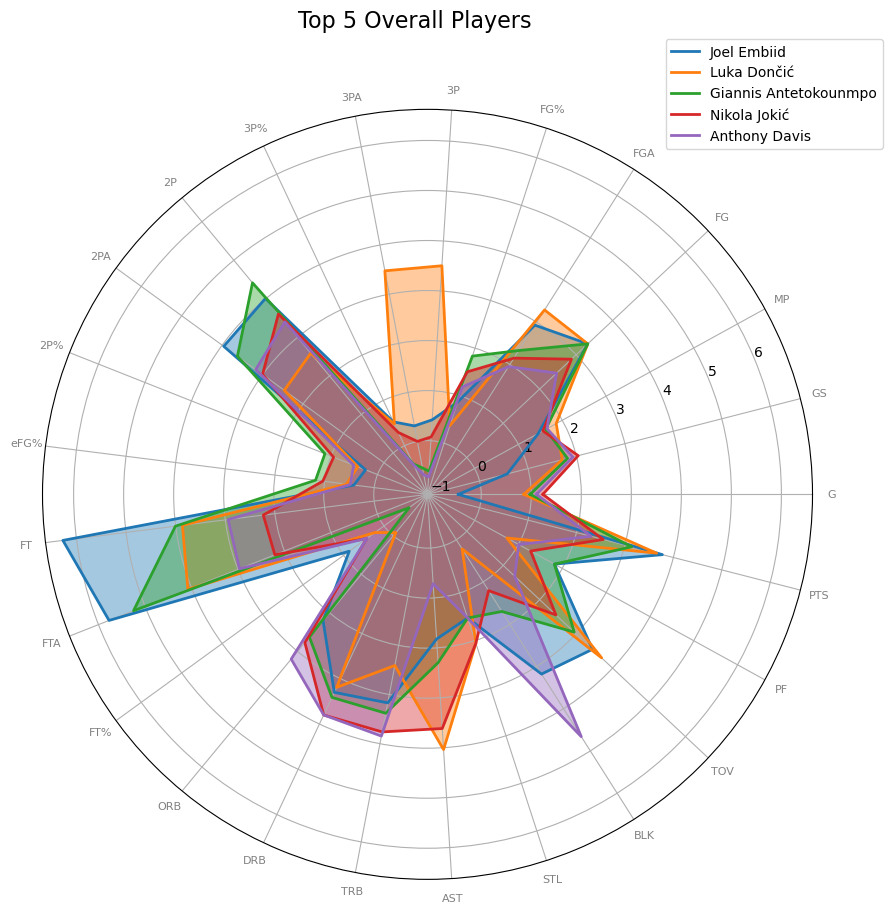

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# Function to create radar charts
def radar_chart(player_data, player_name, ax):
    categories = list(player_data.keys())

    values = list(player_data.values())

    values += values[:1]
    
    angles = [n / float(len(categories)) * 2 * np.pi for n in range(len(categories))]
    
    angles += angles[:1]

    ax.set_xticks(angles[:-1])
    
    ax.set_xticklabels(categories, color='grey', size=8)
    
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=player_name)
    
    ax.fill(angles, values, alpha=0.4)

# Load the data
df = pd.read_csv('filtered.csv')

# prep data
numeric_cols = df.columns[5:]

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Drop rows with missing numeric data
df_cleaned = df.dropna(subset=numeric_cols).copy()

# Normalize the data
scaler = StandardScaler()
df_cleaned[numeric_cols] = scaler.fit_transform(df_cleaned[numeric_cols])

# Define an overall score by summing up all normalized statistics
df_cleaned['OverallScore'] = df_cleaned[numeric_cols].sum(axis=1)

# Select top overall players based on the overall score
top_overall_players = df_cleaned.nlargest(5, 'OverallScore')

# Prepare the plot
fig, axs = plt.subplots(1, 1, figsize=(10, 10), subplot_kw=dict(polar=True))

fig.suptitle('Top 5 Overall Players', size=16)

# Plot radar charts for the top overall players
for index, player in top_overall_players.iterrows():
    
    player_data = player[numeric_cols].to_dict()
    
    radar_chart(player_data, player['Player'], axs)

axs.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

plt.show()
